<a href="https://colab.research.google.com/github/ImperialCollegeLondon/ReCoDE-AIForPatents/blob/main/docs/3_LSTM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. LSTM Classification

From this notebook, you can learn:

- What a LSTM is, and how they can be used for text classification.

- How to train a LSTM using Tensorflow's Keras

- Making predictions using a LSTM, with commentary on the likelihood of predictions.

- Evaluating the performance of the LSTM.

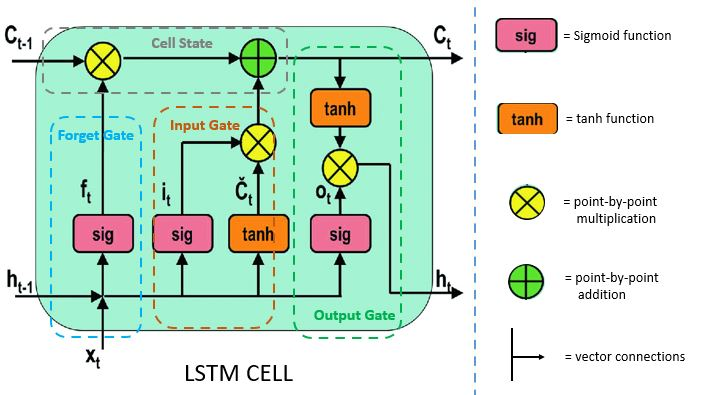

Source: [Introduction to LSTM Units in RNN](https://www.pluralsight.com/guides/introduction-to-lstm-units-in-rnn)

A Long Short-Term Memory (LSTM) network is a type of [recurrent neural network](https://www.ibm.com/topics/recurrent-neural-networks) (RNN) architecture that is designed to handle the challenges of capturing long-term dependencies in sequential data. It overcomes the limitations of traditional RNNs, which struggle to retain information over long sequences due to the [vanishing gradient problem](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484).



The key component of an LSTM network is the LSTM cell, which contains multiple memory cells and gates. Each memory cell stores information and can selectively retain or forget it based on the gate signals. The gates regulate the flow of information through the network and consist of three main parts:

- Forget Gate: Determines what information to discard from the memory cell. It takes the previous hidden state and the current input as inputs and produces a forget gate activation value between 0 and 1 for each memory cell. A value of 0 means the cell should forget the information, while a value of 1 means it should retain it.

- Input Gate: Decides which new information to add to the memory cell. It takes the previous hidden state and the current input and produces an input gate activation value. It also calculates a candidate value for the new information that can be added to the memory cell. The input gate activation value determines how much of the candidate value is incorporated into the memory cell.

- Output Gate: Controls what information should be output from the memory cell. It takes the previous hidden state and the current input as inputs, and based on these, it calculates an output gate activation value. The output gate activation value is used to determine the hidden state of the LSTM cell, which is then passed to the next time step or output layer.

LSTM networks can capture and retain information over long sequences because they have the ability to selectively remember or forget information using the gates. This makes them particularly effective in tasks involving sequential data, such as natural language processing, speech recognition, and time series prediction.

During the training process, the LSTM network adjusts its weights using backpropagation through time, similar to other neural networks. This allows the network to learn patterns and dependencies in the training data, enabling it to make accurate predictions or classifications on unseen data.

To learn more about LSTMs, check out this [video](https://www.youtube.com/watch?v=YCzL96nL7j0), which also explains the vanishing gradient problem that we see in RNNs.

#Importing the modules we will be using

In [1]:
!git clone https://github.com/ImperialCollegeLondon/ReCoDE-AIForPatents.git

Cloning into 'ReCoDE-AIForPatents'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 303 (delta 55), reused 61 (delta 43), pack-reused 224
Receiving objects: 100% (303/303), 37.64 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [2]:
##### MODULE IMPORTS #####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

#Loading the dataset into the workspace and preparing it for use with the ML model

If you want to know how we prepared this dataset, refer to the Web-Scraping Notebook. If you want to learn more about how we prepare the data for use with the model that we train, refer to the Introduction notebook.

In [7]:
def loaddata(GreenCSV, NotGreenCSV):

  """
  Function to create a training dataset and a validation dataset (the validation
  dataset will be kept aside for when we want to evaluate model, to prevent data
  leakage)
  """
  n=90 #percentage of data that will be used during the training of the machine learning model

  #Read in first dataframe
  GreenData_Dataframe = pd.read_csv(GreenCSV)

  #Read in second dataframe
  NotGreenDataFrame = pd.read_csv(NotGreenCSV)

  #Make sure equal number of entries
  MergedDataFrame = pd.concat([GreenData_Dataframe, NotGreenDataFrame[0:len(GreenData_Dataframe)]])

  MergedDataFrame = MergedDataFrame.sample(frac=1, random_state=25) #Shuffle dataframe

  #Get n percent first rows of merged dataframe
  TrainingDataFrame = MergedDataFrame.head(int(len(MergedDataFrame)*(n/100)))

  #Get n percent last rows of merged dataframe
  ValidationDataframe = MergedDataFrame.tail(int(len(MergedDataFrame)*((100-n)/100)))

  #Shuffle dataframe
  FinalDataframe = TrainingDataFrame.sample(frac=1, random_state=25)

  #Shuffle validation dataframe
  ValidationDataframe = ValidationDataframe.sample(frac=1, random_state=25)

  return FinalDataframe, ValidationDataframe

FinalDataframe, ValidationDataframe = loaddata('/content/ReCoDE-AIForPatents/Datasets/GreenPatents_Dataset.csv',
                          '/content/ReCoDE-AIForPatents/Datasets/NotGreenPatents_Dataset.csv')


# Checking for duplicates
total_duplicate_titles = sum(FinalDataframe["Abstract"].duplicated())

# Deleting duplicates
FinalDataframe = FinalDataframe[~FinalDataframe["Abstract"].duplicated()] #Deleting Duplicate values
FinalDataframe = FinalDataframe.dropna() #Deleting Nan values

X_train, X_test, y_train, y_test = train_test_split(
    FinalDataframe["Abstract"].to_numpy(),
    FinalDataframe["GreenV"].to_numpy(),
    test_size=0.1, # 10% of sample in test dataset
    random_state=25)

X_val, X_valnull, Y_val, Y_valnull = train_test_split(
    ValidationDataframe["Abstract"].to_numpy(),
    ValidationDataframe["GreenV"].to_numpy(),
    test_size=0.0001, #Creating dataset for validation
    random_state=25)

# Setting up the Text Vectoriser
text_vectoriser = TextVectorization(
    max_tokens=None, #How many words in the vocabulary (all of the different words in your text)
    standardize="lower_and_strip_punctuation", #How to pre-process text
    split="whitespace", #How to split tokens
    ngrams=None, #Create groups of n-words
    output_mode="int", #How to map tokens to numbers
    output_sequence_length=200) #Based on length of majority of abstracts
    # pad_to_max_tokens=True) # Not valid if using max_tokens= None

#Making inputs compatible with TextVectorisation Layer
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]
X_train = np.array(X_train)
X_test = np.array(X_test)

#Making validation inputs compatible with TextVectorisation Layer for inference
X_val = [str(x) for x in X_val]
X_val = np.array(X_val)

#allows our vectoriser object to computes a vocabulary of  all string tokens seen in the dataset.
#It's sorted by occurrence count, with ties broken by sort order of the tokens (high to low).
text_vectoriser.adapt(X_train)

Vocabulary = text_vectoriser.get_vocabulary()
max_vocab_length = 200

#Setting up Callbacks



In [4]:

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # watch the val loss metric
    patience=5) # if val loss increases for 5 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "Checkpoints/best_model.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

#Compiling and training a LSTM using Keras' Functional API.

In [10]:
#Create embedding layer (new embedding layer for each model)
LSTM_embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=200, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_vocab_length, # how long is each input
                             name="embedding_1")

# Create LSTM model

# inputs are 1-dimensional string objects
inputs = layers.Input(shape=(1,), dtype="string")

#Tokenise and vectorise inp
x = text_vectoriser(inputs)

#Create embedding from tokenised inputs
x = LSTM_embedding(x)

# return vector for whole sequence
x = layers.LSTM(64)(x)

"""
We only have two possible outputs, so we use sigmoid activation function.

A dense layer is a layer that is deeply connected with its preceding layer which
means the neurons of the layer are connected to every neuron of its preceding layer.
"""
outputs = layers.Dense(1, activation="sigmoid")(x)

#Confirm model architecture by merging input and output layers
LSTM = tf.keras.Model(inputs, outputs, name="LSTM")

In [11]:
epochs = 20
# Compile model
LSTM.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [12]:
print(LSTM.summary())

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 200)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 200, 200)          40000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 107905 (421.50 KB)
Trainable params: 107905 (421.50 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

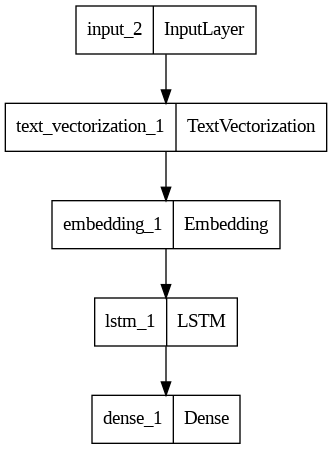

In [13]:
plot_model(LSTM)

In [ ]:
history = LSTM.fit(X_train.astype(object), #Abstract for training
                   y_train, #Abstract classes
                   epochs=epochs, #Defining epochs
                   batch_size=32, #Defining the batch size
                   validation_data=(X_test, y_test), #Test data
                   callbacks=[early_stopping, model_checkpoint]) #Adding callbacks to the training pipeline

Epoch 1/20
 329/3780 [=>............................] - ETA: 5:25 - loss: 0.6938 - accuracy: 0.4993

In [ ]:
def plot_result(item):
    #Retrieving training pipeline data from history object and plotting it
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")

In [ ]:
def calculate_model_accuracy(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred) * 100
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  results = {'accuracy':accuracy,
         'precision': precision,
         'recall': recall,
         'f1': f1_score}

  return results

In [ ]:
# Calculating the performance metrics
LSTM_Predictions = LSTM.predict(X_val)
LSTM_Predictions = tf.squeeze(tf.round(LSTM_Predictions))
LSTM_Result = calculate_model_accuracy(Y_val, LSTM_Predictions)
print(LSTM_Result)

In [ ]:
#Plotting the four metrics on a bar chart
all_results = pd.DataFrame({"LSTM": LSTM_Result})
all_results = all_results.transpose() #Formatting our dataframe so it can be plotted as a bar chart
all_results["accuracy"] = all_results["accuracy"]/100 #Normalising our accuracy score so we can plot it on the bar chart
all_results.plot(kind="bar", figsize=(6, 4))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Model performace evaluation")
plt.ylabel('Score (Out of 1)')
plt.ylim(0.86, 0.88)
plt.tight_layout()


#Extension Tasks
- Train using Sequential API
- Train using a GPU to see difference in speed
- Is it possible to stack LSTM layers? How does this affect performance?
- Play around with Hyperparameters to see if performance can be improved
- Compare performance of this model with models from the other notebooks
- Try using trained models to predict on text that isn't in the dataset? Are there any situations where the model might get confused? Why might this be?

#What's Next?

Now that we have learned a little more about some of the important concepts involved with LSTMs, we can delve into one of the most important NLP architectures today; Transformers!

Check out the PatentClassification_Transformer_Classification notebook!